# The first prototype of the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout.  

Authors: Tobey Carman and Elchin Jafarov

## Working with the docker 
Assuming that docker was successfully installed, navigate to your local dvmdostem folder:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou
import param_util as pu
import os
import subprocess

import Sensitivity


In [74]:
param_specs = [
    {'name':'cmax', 'cmtnum':4, 'pftnum':3, 'bounds':[100,700],'enabled':True },
    {'name':'rhq10', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,5],'enabled':True },
    {'name':'micbnup', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,10],'enabled':True },
]

In [88]:
driver = Sensitivity.SensitivityDriver(param_specs, sample_N=7)

In [89]:
driver.params

[{'name': 'cmax',
  'cmtnum': 4,
  'pftnum': 3,
  'bounds': [100, 700],
  'enabled': True},
 {'name': 'rhq10',
  'cmtnum': 4,
  'pftnum': None,
  'bounds': [0.1, 5],
  'enabled': True},
 {'name': 'micbnup',
  'cmtnum': 4,
  'pftnum': None,
  'bounds': [0.1, 10],
  'enabled': True}]

In [90]:
driver.sample_matrix

,cmax,rhq10,micbnup
0,100.0,0.100000,0.10
1,200.0,0.916667,1.75
2,300.0,1.733333,3.40
3,400.0,2.550000,5.05
4,500.0,3.366667,6.70
5,600.0,4.183333,8.35
6,700.0,5.000000,10.00


In [91]:
%time driver.setup_multi()

PROC:<ForkProcess name='ForkPoolWorker-82' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-81' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-85' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-83' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-87' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-86' parent=115 started daemon>  PROC:<ForkProcess name='ForkPoolWorker-84' parent=115 started daemon>        {'cmax': 500.0, 'rhq10': 3.366666666666667, 'micbnup': 6.7} {'cmax': 100.0, 'rhq10': 0.1, 'micbnup': 0.1}{'cmax': 200.0, 'rhq10': 0.9166666666666667, 'micbnup': 1.7500000000000002}{'cmax': 700.0, 'rhq10': 5.0, 'micbnup': 10.0}{'cmax': 300.0, 'rhq10': 1.7333333333333336, 'micbnup': 3.4000000000000004}{'cmax': 400.0, 'rhq10': 2.5500000000000003, 'micbnup': 5.05}



[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik

kra Found tag:      coeff(0) in maintenance resp. krb(0)  Desc:  Desc: Found tag:  coeff(1) in maintenance resp.(leave)
 krb(0)  Desc: cfall(2) 
  root    coeff(0) in maintenance resp.Found tag: Found tag:
 Desc: 
  Desc:   Found tag:  root Found tag: krb(1)
krb(0)  kra coeff(1) in maintenance resp.(leave) krb(0)Found tag: 
 Desc:   Desc:  Found tag: Desc:    Desc:  krb(1)nfall(0) coeff(1) in maintenance resp.(leave)    coeff(1) in maintenance resp.(leave) 
 coeff(1) in maintenance resp.(leave) Desc:     coeff(0) in maintenance resp. coeff(1) in maintenance resp.(stem)
 Desc: Found tag:
  Found tag:
   leaveFound tag:krb(0) coeff(1) in maintenance resp.(stem)
krb(1)
 Found tag:Found tag:
  Found tag:  Desc: Found tag:krb(1)  Desc:    krb(1) krb(2)krb(2) nfall(1) coeff(1) in maintenance resp.(stem)    coeff(1) in maintenance resp.(leave) Desc:  Desc: 
 Desc:   Desc: 
Found tag:     Desc:  coeff(1) in maintenance resp.(stem)Found tag: coeff(1) in maintenance resp.(root)
  coeff(1) in mai

Found tag:Found tag:  nmaxcmax   Desc:  Desc:   

Found tag:Found tag:  nmaxcfall(0)  Using CMT4 as reference... Desc:  Desc: 
  

Using CMT4 as reference...Found tag:Found tag:Found tag:  
cfall(0)cmax    Desc: cfall(1)  Desc: Found tag:  Desc:    cmax


 Found tag:Found tag:Found tag: Desc:    cfall(1)nmax  
cfall(2) Found tag: Desc:  Desc:     Desc:  nmax
 
 Found tag:Found tag: Desc: 
   cfall(2)Found tag:cfall(0)
   Using CMT4 as reference...Found tag: Desc: 
nfall(0) Desc:     
cfall(0)Found tag:Found tag: Desc: 
  Found tag: Desc:     cmaxnfall(0)

 Found tag:  Desc: cfall(1)Found tag:    Desc:  
cfall(1) Desc:   nfall(1)  Found tag:
 Desc:  Desc: 
   Found tag:Found tag:Using CMT4 as reference...Using CMT4 as reference...
 nfall(1)

cfall(2)
Found tag:   Found tag:nmax Desc:   Desc:  Found tag:Found tag:   cfall(2)
   cmax Desc: Found tag: Desc: nfall(2)
     Found tag:cmax

 Desc: nfall(2) Desc:   Found tag:Found tag:   nfall(0)  Desc: 
nfall(0)  Desc:   

 cfall(0)Found tag:F

In [92]:
%time driver.run_all_samples()

[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000001/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000003/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000000/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000006/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000005/config/config.js[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/sample_000000002/config/config.js





[SA:run] /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctr

In [93]:
driver.collect_outputs()



In [97]:
import glob
file_list = glob.glob('/data/workflows/sensitivity_analysis/**/*sensitivity.csv', recursive=True)
df = pd.concat( map(pd.read_csv, file_list), ignore_index=True)
df = df.sort_values('p_cmax')
print(df)
print()

corr = df.corr()
print(corr)



   p_cmax  p_rhq10  p_micbnup    o_GPP   o_VEGC
0   100.0    0.100       0.10   37.364   65.557
1   200.0    0.917       1.75   74.654  128.371
6   300.0    1.733       3.40  111.897  187.447
3   400.0    2.550       5.05  146.140  234.818
4   500.0    3.367       6.70  170.744  261.950
5   600.0    4.183       8.35  194.666  291.053
2   700.0    5.000      10.00  193.377  285.809

             p_cmax   p_rhq10  p_micbnup     o_GPP    o_VEGC
p_cmax     1.000000  1.000000   1.000000  0.976235  0.959544
p_rhq10    1.000000  1.000000   1.000000  0.976232  0.959539
p_micbnup  1.000000  1.000000   1.000000  0.976235  0.959544
o_GPP      0.976235  0.976232   0.976235  1.000000  0.996723
o_VEGC     0.959544  0.959539   0.959544  0.996723  1.000000


<AxesSubplot:>

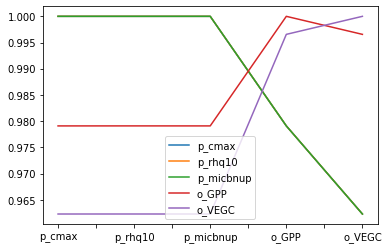

In [72]:
corr.plot()


In [16]:
# Sets initial values from the parameters directory - works better when used with 
# Sensitivity.setup_single() 
# Not sure how to use this yet...
for param in param_specs:
    pfile = pu.which_file(os.path.join(x2.work_dir, "parameters"), param['name'])
    data = pu.get_CMT_datablock(pfile, param['cmtnum'])
    data_dict = pu.cmtdatablock2dict(data)
    if param['pftnum'] is not None:
        pftkey = 'pft{}'.format(param['pftnum'])
        #print(param['name'], data_dict[pftkey][param['name']])
        param['initial_value'] = data_dict[pftkey][param['name']]
    else:
        #print(param['name'], data_dict[param['name']])
        param['initial_value'] = data_dict[param['name']]
    print(param)

